#  High Cost Patient Modeling


In [1]:
#loadin basic modules
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### 1. Prepare for the data

In [6]:
#read in tables, first column is the patientid
full_data = pd.read_csv("C://Users//tianyi.fang//Desktop//TF//projects//ACO//HighCostPatient/model_table0810.csv", index_col=0)
# t_train= pd.read_csv("C:\\Users\\tianyi.fang\\Desktop\\TF\\projects\\ACO\\HighCostPatient\\t_train.csv")
# t_test= pd.read_csv("C:\\Users\\tianyi.fang\\Desktop\\TF\\projects\\ACO\\HighCostPatient\\t_test.csv")


In [9]:
full_x = full_data.loc[:, full_data.columns != 'Label']
full_y = full_data['Label']

In [13]:
print(full_data.head(3))
print(full_x.head(3))
print(full_y.head(3))

           MajorEnrollType  Sex  Age  AssignmentStepFlag    HCCRaf   DemoRaf  \
PatientId                                                                      
5                        4    0   95                   1  2.802642  1.402940   
7                        4    1   81                   1  0.561798  1.207075   
8                        4    1   81                   1  1.388096  1.207075   

           cnt_hha_visit  cnt_inp_visit  cnt_snf_visit  cnt_shortstay  ...    \
PatientId                                                              ...     
5                      0              0              0              0  ...     
7                      0              0              0              0  ...     
8                      0              0              0              0  ...     

           cnt_diag2  cnt_chronic2  cnt_procedure2  total_cost2  cnt_visit3  \
PatientId                                                                     
5                 73            18      

**Split Train_x, trian_y, test_x, test_y**

In [8]:
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, \
                            classification_report, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            roc_curve, \
                            roc_auc_score, \
                        matthews_corrcoef, \
                        f1_score, \
                        auc, make_scorer



In [20]:
train_x, train_y, test_x, test_y = train_test_split(full_x, full_y, test_size = 0.3, random_state = 100, stratify = full_y)

In [3]:
#split train, test and x, and y
# train_y = t_train.Label
# train_x = t_train.drop(['Label'], axis = 1)
# test_y = t_test.Label
# test_x = t_test.drop(['Label'], axis = 1)


In [15]:
#get the column names
train_x.columns.values

array(['MajorEnrollType', 'Sex', 'Age', 'AssignmentStepFlag', 'HCCRaf',
       'DemoRaf', 'cnt_hha_visit', 'cnt_inp_visit', 'cnt_snf_visit',
       'cnt_shortstay', 'cnt_otherstay', 'cnt_visit1', 'cnt_clm_type1',
       'cnt_diag_cd1', 'cnt_admtg_diag', 'cnt_admsn_type', 'cnt_chronic1',
       'total_cost1', 'cnt_visit2', 'cnt_service2', 'cnt_clm_pos2',
       'cnt_ed_visit', 'cnt_diag2', 'cnt_chronic2', 'cnt_procedure2',
       'total_cost2', 'cnt_visit3', 'cnt_clm_pos3', 'cnt_procedure3',
       'total_cost3', 'total_cost'], dtype=object)

In [ ]:
import xgboost as xgb

### 2.Build model with xgboost
Most modules are from sklearn. Refer: <a href = 'https://scikit-learn.org/stable/index.html'>sklearn link </a>


#### 2.1 XGBoost Classifier Introduction
There are 2 type of XGBoost model, one is **xgb.train**, the other is **XGBClassifier**.<br>
XGBClassifier is a Sklearn Wrapper interface for XGBoost.<br>
**1. class xgboost.XGBClassifier**(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, kwargs)<br>
**Parameters** 
+ **max_depth** (int) – Maximum tree depth for base learners.
+ **learning_rate** (float) – Boosting learning rate (xgb’s “eta”)
+ **n_estimators** (int) – Number of trees to fit.
+ verbosity (int) – The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
+ silent (boolean) – Whether to print messages while running boosting. Deprecated. Use verbosity instead.
+ objective (string or callable) – Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).
+ booster (string) – Specify which booster to use: gbtree, gblinear or dart.
+ nthread (int) – Number of parallel threads used to run xgboost. (Deprecated, please use n_jobs)
+ n_jobs (int) – Number of parallel threads used to run xgboost. (replaces nthread)
+ **gamma** (float) – Minimum loss reduction required to make a further partition on a leaf node of the tree.
+ **min_child_weight** (int) – Minimum sum of instance weight(hessian) needed in a child.
+ max_delta_step (int) – Maximum delta step we allow each tree’s weight estimation to be.
+ **subsample** (float) – Subsample ratio of the training instance.
+ **colsample_bytree** (float) – Subsample ratio of columns when constructing each tree.
+ colsample_bylevel (float) – Subsample ratio of columns for each level.
+ colsample_bynode (float) – Subsample ratio of columns for each split.
+ reg_alpha (float (xgb's alpha)) – L1 regularization term on weights
+ reg_lambda (float (xgb's lambda)) – L2 regularization term on weights
+ scale_pos_weight (float) – Balancing of positive and negative weights.
+ base_score – The initial prediction score of all instances, global bias.
+ seed (int) – Random number seed. (Deprecated, please use random_state)
+ random_state (int) – Random number seed. (replaces seed)
+ missing (float, optional) – Value in the data which needs to be present as a missing value. If None, defaults to np.nan.
+ importance_type (string, default "gain") – The feature importance type for the feature_importances_ property: either “gain”, “weight”, “cover”, “total_gain” or “total_cover”.<br>

<b>2. Fit</b><br>
**fit**(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None, sample_weight_eval_set=None, callbacks=None)<br>
**Parameters**
- X (array_like) – Feature matrix
- y (array_like) – Labels
- sample_weight (array_like) – instance weights
- eval_set (list, optional) – A list of (X, y) tuple pairs to use as validation sets, for which metrics will be computed. Validation metrics will help us track the performance of the model.
- sample_weight_eval_set (list, optional) – A list of the form [L_1, L_2, …, L_n], where each L_i is a list of instance weights on the i-th validation set.
- eval_metric (str, list of str, or callable, optional) – If a str, should be a built-in evaluation metric to use. See doc/parameter.rst. If a list of str, should be the list of multiple built-in evaluation metrics to use. If callable, a custom evaluation metric. The call signature is func(y_predicted, y_true) where y_true will be a DMatrix object such that you may need to call the get_label method. It must return a str, value pair where the str is a name for the evaluation and value is the value of the evaluation function. The callable custom objective is always minimized.
- early_stopping_rounds (int) – Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training. Requires at least one item in eval_set. The method returns the model from the last iteration (not the best one). If there’s more than one item in eval_set, the last entry will be used for early stopping. If there’s more than one metric in eval_metric, the last metric will be used for early stopping. If early stopping occurs, the model will have three additional fields: clf.best_score, clf.best_iteration and clf.best_ntree_limit.
- verbose (bool) – If verbose and an evaluation set is used, writes the evaluation metric measured on the validation set to stderr.
- xgb_model (str) – file name of stored XGBoost model or ‘Booster’ instance XGBoost model to be loaded before training (allows training continuation).<br>

<b>3. Predict</b>
<b>predict</b>(data, output_margin=False, ntree_limit=None, validate_features=True)<br>
<b>predict_proba</b>(data, ntree_limit=None, validate_features=True)
**Parameters**
- data (DMatrix) – The dmatrix storing the input.
- output_margin (bool) – Whether to output the raw untransformed margin value.
- ntree_limit (int) – Limit number of trees in the prediction; defaults to best_ntree_limit if defined (i.e. it has been trained with early stopping), otherwise 0 (use all trees).
- validate_features (bool) – When this is True, validate that the Booster’s and data’s feature_names are identical. Otherwise, it is assumed that the feature_names are the same.<br>


In [16]:
#convert to xgb table format, with variable name available for feature importance displaying
dtrain = xgb.DMatrix(train_x, label = train_y, feature_names= train_x.columns.values)
dtest = xgb.DMatrix(test_x, label = test_y)

C:\Users\tianyi.fang\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\tianyi.fang\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [17]:
dtrain.feature_names[1:4]

['Age', 'AssignmentStepFlag', 'HCCRaf']

In [21]:
#try the very base model without any tuning
param = {  
         'eval_metric' : 'auc' ,            #when use hyperthread, xgboost may become slower
         'objective':'binary:logistic',              #binary classification
         'learning_rate': 0.05,                      #so called `eta` value
         'max_depth': 6,
         'min_child_weight': 1,
         'subsample': 1,
         'colsample_bytree': 1}
eval_list = [(dtest, 'eval'), (dtrain, 'train')]

In [22]:
#train basic model
basex = xgb.train(param, dtrain, 10, eval_list, early_stopping_rounds=100)

[0]	eval-auc:0.762334	train-auc:0.825899
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 100 rounds.
[1]	eval-auc:0.76559	train-auc:0.837797
[2]	eval-auc:0.779499	train-auc:0.846444
[3]	eval-auc:0.77774	train-auc:0.850656
[4]	eval-auc:0.776581	train-auc:0.851564
[5]	eval-auc:0.777736	train-auc:0.852941
[6]	eval-auc:0.773018	train-auc:0.854884
[7]	eval-auc:0.772197	train-auc:0.858751
[8]	eval-auc:0.77031	train-auc:0.859521
[9]	eval-auc:0.773504	train-auc:0.862233


In [16]:
#save model
basex.save_model('001.model')

#### 2.2 feature importance

In [23]:
#faeture importance score, based on different importance type
basex.get_score(importance_type='gain')

{'total_cost': 42.80430604815117,
 'HCCRaf': 17.304016302142855,
 'total_cost2': 4.757178685695652,
 'Age': 2.919635452781579,
 'cnt_visit3': 2.4973164722999996,
 'cnt_chronic1': 2.8534153783846152,
 'cnt_diag2': 3.2546377648333333,
 'cnt_service2': 8.171958328064516,
 'cnt_procedure2': 2.6230325930580958,
 'total_cost1': 7.127460845114285,
 'cnt_visit1': 4.7567450860000005,
 'cnt_visit2': 3.68679833672973,
 'total_cost3': 2.9591204525,
 'AssignmentStepFlag': 2.920152051428571,
 'DemoRaf': 4.576998634090909,
 'Sex': 4.17930031,
 'cnt_diag_cd1': 4.43852075,
 'cnt_hha_visit': 14.898294068000002,
 'cnt_ed_visit': 5.5958273784615375,
 'cnt_chronic2': 5.844534934407405,
 'cnt_clm_pos2': 2.3738742214285713,
 'cnt_procedure3': 2.9984228827272728,
 'cnt_admtg_diag': 8.09589195,
 'cnt_inp_visit': 4.774571736666666,
 'cnt_clm_type1': 5.57224798}

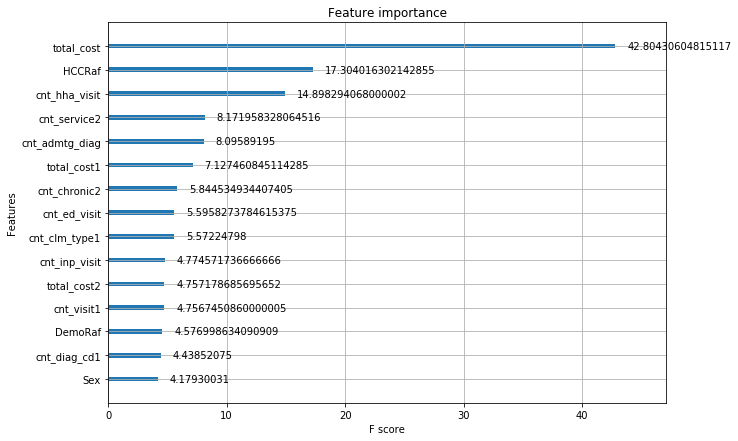

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
xgb.plot_importance(basex,  max_num_features=15, importance_type='gain', ax = ax)

#### 2.3 metric function

In [113]:
metrics_list = ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1_Score']
##### this function require: y in train, y_pred in train, y in test, and y_pred in test
def get_performance_metrics(ytrain, ytrain_p, yvalid, yvalid_p):
    metrics_df = pd.DataFrame(columns = ['train', 'valid'])
    metrics_df.loc['Accuracy'] = [accuracy_score(ytrain, ytrain_p), accuracy_score(yvalid, yvalid_p)]
    metrics_df.loc['Precision'] = [precision_score(ytrain, ytrain_p), precision_score(yvalid, yvalid_p)]
    metrics_df.loc['Recall'] = [recall_score(ytrain, ytrain_p), recall_score(yvalid, yvalid_p)]
    metrics_df.loc['f1_score'] = [f1_score(ytrain, ytrain_p), f1_score(yvalid, yvalid_p)]
    metrics_df.loc['AUC'] = [roc_auc_score(ytrain, ytrain_p), roc_auc_score(yvalid, yvalid_p)]
    metrics_df.loc['Matthews_Corrcoef'] = [matthews_corrcoef(ytrain, ytrain_p), matthews_corrcoef(yvalid, yvalid_p)]
    return metrics_df


def get_confusion_matrix(y_valid, y_predict):
    cm = pd.DataFrame(confusion_matrix(y_valid, y_predict), \
                      columns = ['Predicted Low', 'Predicted High'], \
                      index = ['True Low', 'True High'])
    return cm
##### this requires y in train, y_prob in train, y in test, and y_prob in test
def plot_roc_curve(y_train, y_train_prob, y_valid, y_valid_prob, model):
    fpr, tpr, threshold = roc_curve(y_train, y_train_prob)
    fpr_valid, tpr_valid, threshold_valid = roc_curve(y_valid, y_valid_prob)
    roc_auc_train = auc(fpr, tpr)
    roc_auc_valid = auc(fpr_valid, tpr_valid)
    
    #plot roc curve
    plt.figure()
    plt.title('Receiver Operating Characteristic of ' + model)
    plt.plot(fpr, tpr, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_valid, tpr_valid, 'r', label = 'Test AUC = %0.2f' % roc_auc_valid)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def evaluation_func(train_x, train_y, test_x, test_y ,fitted_model):
    
    #y_train is the actual label in train set, y_train_p is the prediction label in train set,     
    #check the model preformance on test data
    y_test_prediction = fitted_model.predict(test_x) #return 1 or 0
    y_train_prediction = fitted_model.predict(train_x)
    y_test_probability = fitted_model.predict_proba(test_x)[:,1]
    y_train_probability = fitted_model.predict_proba(train_x)[:,1]
    
    #get confusion matrix:
    print(get_confusion_matrix(test_y, y_test_prediction))
    #get metrics:
    print(get_performance_metrics(train_y, y_train_prediction, test_y, y_test_prediction))
    #get roc curve
    plot_roc_curve(train_y, y_train_probability, test_y, y_test_probability, 'This model')

In [26]:
#check the model preformance on test data
y_test_prob = basex.predict(dtest, ntree_limit=basex.best_ntree_limit )
y_train_prob = basex.predict(dtrain,ntree_limit=basex.best_ntree_limit )

In [27]:
y_test_pred = np.where(y_test_prob >0.5, 1, 0)
y_train_pred = np.where(y_train_prob >0.5, 1, 0)

#### 2.4 Evaluation of base model

In [114]:
get_confusion_matrix(test_y,y_test_pred)

,Predicted Low,Predicted High
True Low,1066,40
True High,145,57


In [115]:
get_performance_metrics(train_y, y_train_pred, test_y, y_test_pred)

,train,valid
Accuracy,0.904434,0.858563
Precision,0.859532,0.587629
Recall,0.435593,0.282178
f1_score,0.578178,0.381271
AUC,0.711498,0.623006
Matthews_Corrcoef,0.569843,0.339275


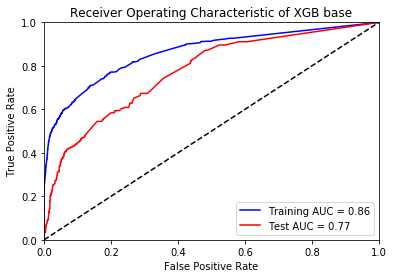

In [116]:
#get the metrics
plot_roc_curve(train_y, y_train_prob, test_y, y_test_prob, 'XGB base')

#### 2.5.Tuning parameters for xgboost
Starting from General Parameter(high learning rate) -->Tree-specific parameters --> regularization paramaters --> lower the learning rate to choose the optimal model
There are also random search vs grid search
**XGBClassifier in sklearn**
In order to better cv and grid search, using XGBClassifier

#### 2.6 RandomizedSearchCV
class sklearn.model_selection.RandomizedSearchCV(estimator, param_distributions, n_iter=10, scoring=None, n_jobs=None, iid='warn', refit=True, cv='warn', verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score='raise-deprecating', return_train_score=False)
- estimator
- param_distributions:
- n_iter: default = 10: @ of parameter settings that are sampled.  it trades off runtime vs quality of the solution
- scoring: 
- n_jobs
- iid
- cv
- refit
- random_states

In [33]:
#first get the base model with assigned learning rate and n_estimator
xgbbase = xgb.XGBClassifier(nthreads = 4, eval_metric = 'auc', objective = 'binary:logistic', 
                           learning_rate = 0.05, n_estimators = 1000)

In [34]:
#first do random search to shrink the parameter pool
random_grid = {
    'max_depth': np.arange(3, 18, 3),
    'min_child_weight' : np.arange(2,12,2),
    'gamma' : np.arange(0, 1, 0.1),
    'subsample':np.arange(0, 1, 0.1),
    'colsample_bytree':np.arange(0, 1, 0.1)    
}

In [35]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [38]:
random_xgb = RandomizedSearchCV(estimator = xgbbase, param_distributions = random_grid,
                          cv = 5, n_iter = 20, random_state = 23, n_jobs = -1, scoring =scoring, refit = 'AUC' )
random_xgb.fit(train_x,train_y) #train on training dataset

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='auc', gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, nthreads=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'max_depth': array([ 3,  6,  9, 12, 15]), 'min_child_weight': array([ 2,  4,  6,  8, 10]), 'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'subsample': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'colsample_bytree': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
          pre_dispatch='2*n_jobs', random_state=23, refit='AUC',
      

In [39]:
print(random_xgb.best_estimator_)
print(random_xgb.best_score_ , random_xgb.best_params_ )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.1, eval_metric='auc',
       gamma=0.0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, nthreads=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)
0.780622134018801 {'subsample': 0.7000000000000001, 'min_child_weight': 2, 'max_depth': 3, 'gamma': 0.0, 'colsample_bytree': 0.1}


<b>From the result of random search, we can see the subsample around 0.8, mid_child_weight around 4, max_depth around 3, gamma around 0.4 and colsample_bytree around 0.5 is the best parameter combination. So the grid search will be around this combination.</b>

#### 2.7 GridSearchCV
class sklearn.model_selection.GridSearchCV
(estimator, param_grid, scoring=None, n_jobs=None, iid='warn', refit=True, cv='warn', verbose=0, \
 pre_dispatch='2*n_jobs', error_score='raise-deprecating', return_train_score=False)
- estimator: the model you specify, 
- param_grid: the extend_grid, 
- scoring: a string to evaluate the predictions on test
- scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
- n_jobs:run in parallel, -1 means using all processors.
- iid: True, return the avg score across folds. weighted by # of samples in each test set.(In this case, \
data is assumed to be identically distributed across the folds, and the loss minimized is the total loss \ 
per sample, and not the mean loss across the folds. If False, return the average score across folds.
)
- cv: cross validation generator. integer can be specified in StratifiedKFold().
- refit: when you have mulitple evaluation metrics, refit the model using best found parameters on the whole set.


In [110]:
x_param_grid = {
    'max_depth': [2,3,4,5],
    'min_child_weight' : [2,3,4,5,6],
    'gamma' : [0.2, 0.3, 0.4, 0.5],
    'subsample':[0.6, 0.65, 0.7, 0.75, 0.8, 0.85],   #since the random search already done 0.1, change the step to 0.05
    'colsample_bytree':[0.35, 0.4,0.45, 0.5,0.55, 0.6, 0.65]     #since the random search already done 0.1
}

In [99]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.1.


In [111]:
grid_xgb = GridSearchCV(estimator = xbase_model, param_grid=x_param_grid, 
             cv = 3,  n_jobs = -1, scoring =scoring, refit = 'AUC')
grid_xgb.fit(train_x,train_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='auc', gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, nthreads=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5], 'min_child_weight': [2, 3, 4, 5, 6], 'gamma': [0.2, 0.3, 0.4, 0.5], 'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85], 'colsample_bytree': [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=0)

In [112]:

#check result
print(grid_xgb.best_estimator_)
print(grid_xgb.best_score_ , grid_xgb.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
       gamma=0.4, learning_rate=0.05, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, nthreads=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.6, verbosity=1)
0.777600407195609 {'colsample_bytree': 0.5, 'gamma': 0.4, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6}


In [113]:
#default parameters
xbase2_model =xgb.XGBClassifier(nthreads = 4, eval_metric = 'auc', objective = 'binary:logistic', 
                           max_depth = 2, min_child_weight =6 , gamma = 0.4 , subsample = 0.6, colsample_bytree =0.5 )

In [144]:
xbase2_model.fit(test_x, test_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, nthreads=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.6, verbosity=1)

In [ ]:
#show the preformance of xbase2
evaluation_func(train_x, train_y, test_x, test_y ,fitted_model):

<B>Then need to tuning learning_rate with n_estimators</b>

In [116]:
random_grid2 = {'n_estimators': np.arange(100, 5000, 500),
              'learning_rate': np.arange(0, 1, 0.1), 
             }

In [117]:
random_xgb2 = RandomizedSearchCV(estimator = xbase2_model, param_distributions = random_grid2,
                          cv = 3, n_iter = 20, random_state = 24, n_jobs = -1, scoring =scoring, refit = 'AUC')
random_xgb2.fit(test_x,test_y)
print(random_xgb2.best_estimator_)
print(random_xgb2.best_score_ , random_xgb2.best_params_ )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
       gamma=0.4, learning_rate=0.2, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, nthreads=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.6, verbosity=1)
0.7516799858389012 {'n_estimators': 100, 'learning_rate': 0.2}


In [119]:
np.arange(200, 2000, 200)

array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800])

In [120]:
x_param_grid2 = {'n_estimators': np.arange(200, 2000, 200),
              'learning_rate': [0.001, 0.001, 0.005, 0.1, 0.3], 
             }

In [121]:
grid_xgb2 = GridSearchCV(estimator = xbase2_model, param_grid=x_param_grid2, 
             cv = 3,  n_jobs = -1, scoring =scoring, refit = 'AUC')
grid_xgb2.fit(train_x,train_y)

#check result
print(grid_xgb2.best_estimator_)
print(grid_xgb2.best_score_ , grid_xgb2.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
       gamma=0.4, learning_rate=0.005, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, nthreads=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.6, verbosity=1)
0.7960548178576639 {'learning_rate': 0.005, 'n_estimators': 1200}


In [122]:
xgb_best = xgb.XGBClassifier(nthreads = 4, eval_metric = 'auc', objective = 'binary:logistic', 
                           max_depth = 2, min_child_weight = 6, gamma = 0.4, subsample =0.6 , colsample_bytree =0.6 ,
                            learning_rate =0.005 , n_estimators =1200 )


In [123]:
xgb_best.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
       gamma=0.4, learning_rate=0.005, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, nthreads=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.6, verbosity=1)

In [134]:
#check the model preformance on test data
y_test_pred1 = xgb_best.predict(test_x) #return 1 or 0
y_train_pred1 = xgb_best.predict(train_x)
y_test_prob1 = xgb_best.predict_proba(test_x)[:,1]
y_train_prob1 = xgb_best.predict_proba(train_x)[:,1]

C:\Users\tianyi.fang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tianyi.fang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [117]:
get_confusion_matrix(test_y,y_test_pred1)

NameError: name 'y_test_pred1' is not defined

In [136]:
get_performance_metrics(train_y, y_train_pred1, test_y, y_test_pred1)

,train,valid
Accuracy,0.880989,0.865443
Precision,0.757322,0.675676
Recall,0.306780,0.247525
f1_score,0.436671,0.362319
AUC,0.644692,0.612912
Matthews_Corrcoef,0.432478,0.353225


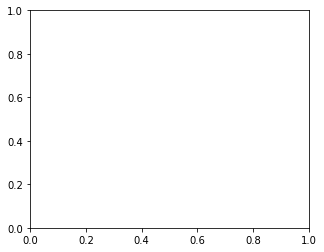

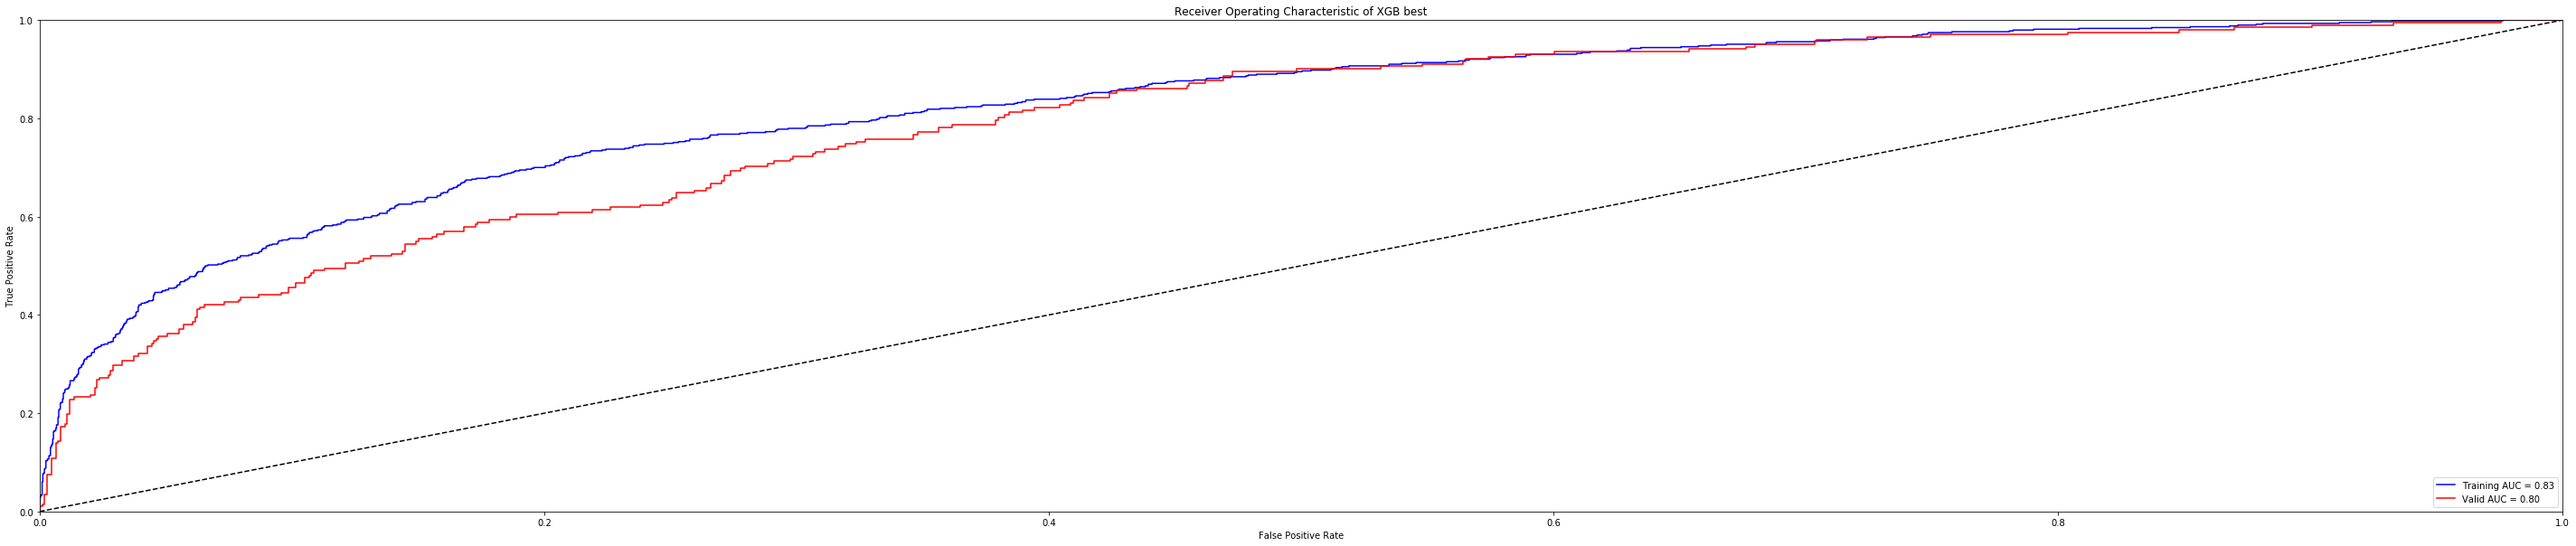

In [138]:

plot_roc_curve(train_y, y_train_prob1, test_y, y_test_prob1, 'XGB best')

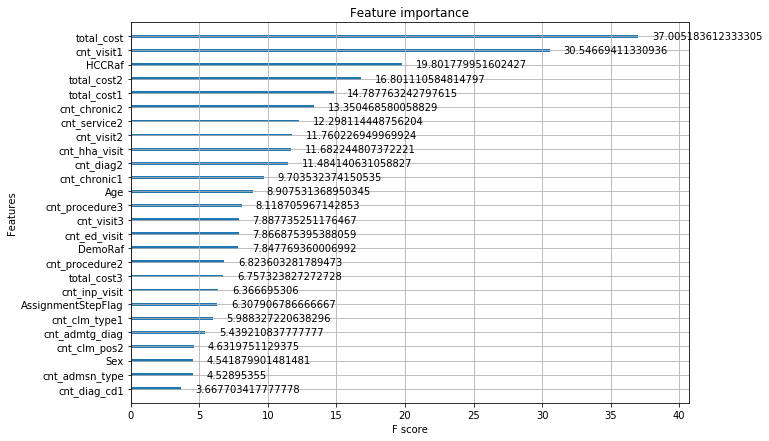

In [141]:
fig, ax = plt.subplots(figsize=(10, 7))
xgb.plot_importance(xgb_best,importance_type='gain', ax = ax)

### 3.Build model with lightgbm
LightGBM is much faster and more accurate classification model. check<a href ='https://www.kdnuggets.com/2018/03/catboost-vs-light-gbm-vs-xgboost.html'>Adanvatage of LightGBM</a>
#### 3.1 Lightgbm base model 

In [16]:
import lightgbm as lgb

In [121]:
eval_set = [(test_x, test_y)]

In [17]:
#get the base model
lgb_base1 = lgb.LGBMClassifier()

**Notice default model using 'split' as importance_type. There is another option of 'gain' which allows to split by information gain**

If 'split', result contains numbers of times the feature is used in a model. If 'gain', result contains total gains of splits which use the feature.

In [130]:
lgb_base1

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [141]:
#train model in the base lgb
lgb_base1.fit(train_x, train_y,eval_set =eval_set, eval_metric='roc_auc', early_stopping_rounds= 10)

[1]	valid_0's binary_logloss: 0.408269
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.394679
[3]	valid_0's binary_logloss: 0.385735
[4]	valid_0's binary_logloss: 0.379472
[5]	valid_0's binary_logloss: 0.374943
[6]	valid_0's binary_logloss: 0.371435
[7]	valid_0's binary_logloss: 0.367889
[8]	valid_0's binary_logloss: 0.365285
[9]	valid_0's binary_logloss: 0.362038
[10]	valid_0's binary_logloss: 0.359613
[11]	valid_0's binary_logloss: 0.35786
[12]	valid_0's binary_logloss: 0.358027
[13]	valid_0's binary_logloss: 0.357663
[14]	valid_0's binary_logloss: 0.35573
[15]	valid_0's binary_logloss: 0.355887
[16]	valid_0's binary_logloss: 0.356418
[17]	valid_0's binary_logloss: 0.355718
[18]	valid_0's binary_logloss: 0.355361
[19]	valid_0's binary_logloss: 0.355669
[20]	valid_0's binary_logloss: 0.355492
[21]	valid_0's binary_logloss: 0.355106
[22]	valid_0's binary_logloss: 0.354816
[23]	valid_0's binary_logloss: 0.354792
[24]	valid_0's binary_logloss

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [142]:
print(lgb_base1.best_iteration_)
print(lgb_base1.best_score_)

23
defaultdict(<class 'dict'>, {'valid_0': {'binary_logloss': 0.35479214156625094}})


#### 3.2 Evaluation

           Predicted Low  Predicted High
True Low            1083              23
True High            145              57
                      train     valid
Accuracy           0.907492  0.871560
Precision          0.901060  0.712500
Recall             0.432203  0.282178
f1_score           0.584192  0.404255
AUC                0.711903  0.630691
Matthews_Corrcoef  0.585560  0.394172


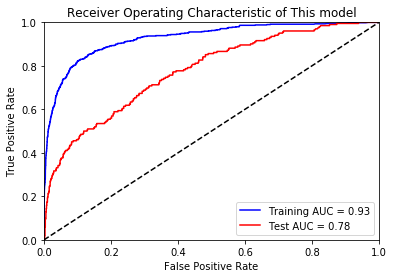

In [133]:

evaluation_func(train_x, train_y, test_x, test_y ,lgb_base1)

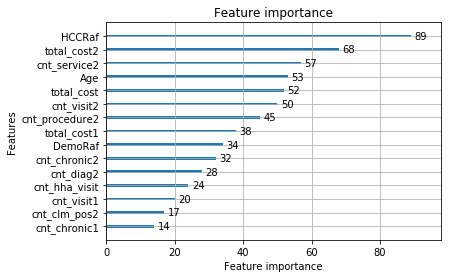

In [135]:
lgb.plot_importance(lgb_base1, max_num_features=15, importance_type='split')

**Now try 'gain' as importance_type**

In [136]:
lgb_base2 = lgb.LGBMClassifier(importance_type='gain')

In [137]:
lgb_base2.fit(train_x, train_y,eval_set =eval_set, eval_metric='roc_auc', early_stopping_rounds= 10)
print(lgb_base2.best_iteration_)
print(lgb_base2.best_score_)

[1]	valid_0's binary_logloss: 0.408269
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.394679
[3]	valid_0's binary_logloss: 0.385735
[4]	valid_0's binary_logloss: 0.379472
[5]	valid_0's binary_logloss: 0.374943
[6]	valid_0's binary_logloss: 0.371435
[7]	valid_0's binary_logloss: 0.367889
[8]	valid_0's binary_logloss: 0.365285
[9]	valid_0's binary_logloss: 0.362038
[10]	valid_0's binary_logloss: 0.359613
[11]	valid_0's binary_logloss: 0.35786
[12]	valid_0's binary_logloss: 0.358027
[13]	valid_0's binary_logloss: 0.357663
[14]	valid_0's binary_logloss: 0.35573
[15]	valid_0's binary_logloss: 0.355887
[16]	valid_0's binary_logloss: 0.356418
[17]	valid_0's binary_logloss: 0.355718
[18]	valid_0's binary_logloss: 0.355361
[19]	valid_0's binary_logloss: 0.355669
[20]	valid_0's binary_logloss: 0.355492
[21]	valid_0's binary_logloss: 0.355106
[22]	valid_0's binary_logloss: 0.354816
[23]	valid_0's binary_logloss: 0.354792
[24]	valid_0's binary_logloss

           Predicted Low  Predicted High
True Low            1083              23
True High            145              57
                      train     valid
Accuracy           0.907492  0.871560
Precision          0.901060  0.712500
Recall             0.432203  0.282178
f1_score           0.584192  0.404255
AUC                0.711903  0.630691
Matthews_Corrcoef  0.585560  0.394172


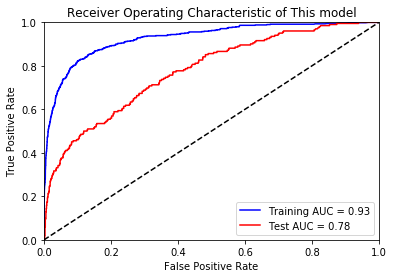

In [138]:
evaluation_func(train_x, train_y, test_x, test_y ,lgb_base2)

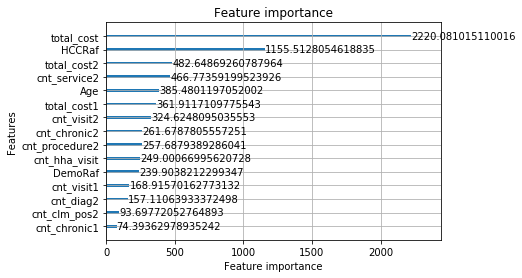

In [139]:
lgb.plot_importance(lgb_base2, max_num_features=15, importance_type='gain')

**No matter using split or gain, the result is the same**

#### 3.3 Tuning parameters with sklearn API

**class lightgbm.LGBMClassifier**(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)<br>

<img src ='LGBMClassifier_parameter.png'>
<a href = 'https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier'>Reference of sklearn LGBMClassifier</a>

Identical parameters:
- min_data_in leaf: min_child_samples
- bagging fraction/bagging_freq: subsample/subsample_freq
- feature_fraction: colsample_bytree
- max_bin:
- num_iterations:
- min_sum_hessian_in_leaf: min_child_weight 


In [151]:
from lightgbm import LGBMClassifier

First set the fit_parameters for all models

In [99]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : {'logloss','roc_auc'},
            "eval_set" : [(test_x, test_y)],
            'eval_names': ['test']}

##### Test1 RandomSearchCV
- 1.Leaf-wise Tree: if set max_depth = -1(unlimited) could cause overfitting
- 2.Better Accuracy
- Deal with Over-fitting

**Fix: n_jobs= 4,boosting_type = 'gbdt',  objective = 'binary',importance_type = 'gain',boosting_type ='gbdt',
        learning_rate= 0.1, n_estimators = 2000, 
        max_depth = 7**

In [154]:
#set the base LGBMClassifier with fixed core parameters
lgb_m1 = LGBMClassifier(n_jobs = 4, 
                        boosting_type= 'gbdt', 
                        objective='binary', 
                        importance_type='gain', 
                        learning_rate=0.1, 
                        n_estimators=500)

In [157]:
rand_param = {'max_depth': np.arange(1,15,1),              #tree depth
              'num_leaves': np.arange(10, 200, 40),         #lead depth
              'min_split_gain': sp.stats.uniform(0, 5.0),   #Minimum loss reduction required to make a further partition on a leaf node of the tree.
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1], 
              'min_child_samples': np.arange(5,50,5),
              'subsample': np.arange(0.4, 1, 0.1),          #– Subsample ratio of the training instance.
              'colsample_bytree': np.arange(0.4, 1, 0.1),   #– Subsample ratio of columns
              'reg_alpha': sp.stats.uniform(0, 1e-2),       #– L1 regularization term on weights.
              'reg_lambda': sp.stats.uniform(0, 1e-2),      #– L2 regularization term on weights.
             }

In [158]:
rand_lgb = RandomizedSearchCV(lgb_m1, rand_param, n_iter = 100, cv = 5, refit = True, random_state= 11)

In [162]:
# rand_lgb.fit(train_x, train_y)
rand_lgb.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7999999999999999, importance_type='gain',
        learning_rate=0.1, max_depth=9, min_child_samples=40,
        min_child_weight=0.1, min_split_gain=4.9126673477688785,
        n_estimators=500, n_jobs=4, num_leaves=170, objective='binary',
        random_state=None, reg_alpha=0.003181191073565963,
        reg_lambda=0.002818299573281393, silent=True,
        subsample=0.8999999999999999, subsample_for_bin=200000,
        subsample_freq=0)

           Predicted Low  Predicted High
True Low            1087              19
True High            149              53
                      train     valid
Accuracy           0.882773  0.871560
Precision          0.770833  0.736111
Recall             0.313559  0.262376
f1_score           0.445783  0.386861
AUC                0.648531  0.622599
Matthews_Corrcoef  0.443089  0.388502


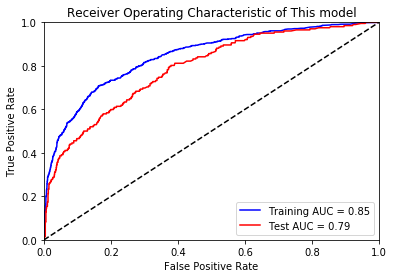

In [161]:
evaluation_func(train_x, train_y, test_x, test_y ,rand_lgb)

**Then using grid search on the same parameter set and see the performance**

But since grid search will go through all the values, all values should be array or str

In [165]:
grid_param = {'max_depth': np.arange(1,15,1),              #tree depth
              'num_leaves': np.arange(10, 200, 40),         #lead depth
              'min_split_gain': np.arange(0, 6, 0.5),   #Minimum loss reduction required to make a further partition on a leaf node of the tree.
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1], 
              'min_child_samples': np.arange(5,50,5),
              'subsample': np.arange(0.4, 1, 0.1),          #– Subsample ratio of the training instance.
              'colsample_bytree': np.arange(0.4, 1, 0.1),   #– Subsample ratio of columns
              'reg_alpha': np.arange(0, 1e-2, 1e-3),       #– L1 regularization term on weights.
              'reg_lambda': np.arange(0, 1e-2, 1e-3),      #– L2 regularization term on weights.
             }

**It seems n_jobs = 4 will run forever, so change to n_jobs =1, which only affect the execution time**

In [169]:
lgb_m2 = LGBMClassifier(n_jobs = 1, boosting_type= 'gbdt', objective='binary', 
                        importance_type='gain', learning_rate=0.1, n_estimators=500)

In [170]:
grid_lgb = GridSearchCV(lgb_m2, grid_param, cv = 5, refit = True)

In [171]:
grid_lgb.fit(train_x, train_y)


MemoryError: 

In [ ]:
grid_lgb.best_estimator_

In [ ]:
evaluation_func(train_x, train_y, test_x, test_y ,grid_lgb)

In [ ]:
def classification_fit(model,
                       cv_parameter,
                       model_name):
    cv_model = GridSearchCV(model, cv_parameters)

    #--------------------------------------------------------------
    # 1. FITTING MODEL
    #--------------------------------------------------------------
    start_time = time.time()
    cv_model.fit(x_train, y_train)
    end_time = time.time()

    best_model = cv_model.best_estimator_

    print("Printing results...")
    print("=========================================================")
    print("  Model:",model_name)
    print("=========================================================")
    print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
    print("Optimal parameters:")
    print(cv_model.best_params_)
    print(("model fitting completed.."))
    #--------------------------------------------------------------
    # 2. PREDICT PROBABILITIES
    #--------------------------------------------------------------
    try:
        y_pred_probs = best_model.predict_proba(x_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)   
        probs_predicted = True
    except:
        probs_predicted = False
        
    #--------------------------------------------------------------
    # 3. PREDICT PROBABILITIES ON BEST THRESHOLD
    #--------------------------------------------------------------    
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(x_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.astype('int').sum())
        true_neg_train = (1 - fpr_train) *(1 - y_train.astype('int')).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        print("Accuracy-maximizing threshold was: " ,round((best_threshold),3))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(x_test)

    print("Accuracy: ", round(accuracy_score(y_test, y_pred),4))
    print(classification_report(y_test, y_pred, target_names =['Retain', 'Churn'], digits = 4))
    print("value prediction completed...")
    
    #----------------------------------------------------------------
    # PERFORMANCE ANALYSIS & CALIBRATION
    #----------------------------------------------------------------
    
    # CALIBRATION
   
     
    plt.figure(figsize = (34, 11.5))
    plt.subplot(2, 2, 1)

    plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
    plt.plot(fpr, tpr, 'b')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1]); plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.subplot(2, 2, 3)

    plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
    plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
    plt.legend(loc = 'lower right')
    plt.xlim([0,1]); plt.ylim([0,1])
    plt.xlabel('Threshold')

    plt.subplot(2, 2, 2)
    
    #BEFORE CALIBRATION
    
    fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
    plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
    plt.plot(mpv_0, fp_0, 's-' )
    plt.ylabel('Fraction of Positives')
    plt.xlim([0,1]); plt.ylim([0,1])
    plt.legend(loc ='upper left')
    
  

    
             
    plt.subplot(2, 2, 4)
    plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
    plt.xlim([0,1]); plt.ylim([0,300])
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Count')
            
    #plt.tight_layout()
    plt.show()

    brier_score = brier_score_loss(y_test, y_pred_probs)
    print("Brier score:", round(brier_score,2))

    #probas_cv = clf_cv.predict_proba(X_test)
    clf_score =  log_loss(y_test, y_pred_probs)
    print('uncalibrated log-loss:',round(clf_score,3))
